<a href="https://colab.research.google.com/github/zaedulislam/3D_Human_Pose_Estimation/blob/main/Higher_order_and_Multi_hop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Libraries

In [ ]:
!pip install 'networkx<2.7'
!pip install 'scipy>=1.8'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy

## Skeleton Graph

### Skeleton Edges

In [ ]:
neighbour_base = [(0, 1), (1, 2), (2, 3), (0, 4), (4, 5), (5, 6),
                  (0, 7), (7, 8), (8, 9), (8, 10), (10, 11),
                  (12, 11), (8, 13), (13, 14), (14, 15)]

### Creating skeleton graph

In [ ]:
G = nx.Graph(neighbour_base)

### Adjacency matrix of skeleton (G)

In [ ]:
A = nx.adjacency_matrix(G)
print(A)

  (0, 1)	1
  (0, 4)	1
  (0, 7)	1
  (1, 0)	1
  (1, 2)	1
  (2, 1)	1
  (2, 3)	1
  (3, 2)	1
  (4, 0)	1
  (4, 5)	1
  (5, 4)	1
  (5, 6)	1
  (6, 5)	1
  (7, 0)	1
  (7, 8)	1
  (8, 7)	1
  (8, 9)	1
  (8, 10)	1
  (8, 13)	1
  (9, 8)	1
  (10, 8)	1
  (10, 11)	1
  (11, 10)	1
  (11, 12)	1
  (12, 11)	1
  (13, 8)	1
  (13, 14)	1
  (14, 13)	1
  (14, 15)	1
  (15, 14)	1


In [ ]:
A = A.todense()
print("Adjacency matrix representation of G:\n", A)

Adjacency matrix representation of G:
 [[0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


### Drawing skeleton graph

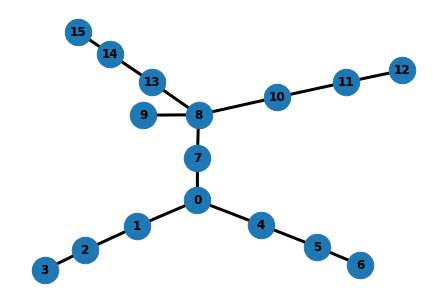

In [ ]:
options = {
    # 'node_color': 'black',
    'node_size': 700,
    'width': 3,
}
nx.draw(G, with_labels=True, font_weight='bold', **options)

In [ ]:
def draw_graph(G):
    options = {
        # 'node_color': 'black',
        'node_size': 700,
        'width': 3,
    }   
    nx.draw(G, with_labels=True, font_weight='bold', **options)

## Utility Functions

In [ ]:
def adjacency_to_graph(adjacency_matrix):
    G = nx.Graph(adjacency_matrix, nodetype=int)
    return G

In [ ]:
def find_path(G,u,n):
    if n==0:
        return [[u]]
    paths = [[u]+path for neighbor in G.neighbors(u) for path in find_path(G,neighbor,n-1) if u not in path]

    return paths

In [ ]:
def get_k_adjacency(A, k, with_self=False, self_factor=1):
    I = np.eye(len(A), dtype=A.dtype)

    if k == 0:
        return I

    Ak = np.minimum(np.linalg.matrix_power(A + I, k), 1) \
       - np.minimum(np.linalg.matrix_power(A + I, k - 1), 1)

    if with_self:
        Ak += (self_factor * I)
        
    return Ak

## Higher-order Matrix
Number of walks of length *k* between node *i* and *j*

### First-order adjacency matrix (Aˆ1)

In [ ]:
A_1 = A
print(A_1)

[[0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


### Second-order adjacency matrix (Aˆ2) 

In [ ]:
A_2 = np.matmul(A_1, A_1)
print(A_2)

[[3 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 2 0 1 1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 2 0 1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 2 0 1 1 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 4 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1 2 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 2 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]]


### Third-order adjacency matrix (Aˆ3)

In [ ]:
A_3 = np.matmul(A_2, A_1)
print(A_3)

[[0 4 0 1 4 0 1 4 0 1 1 0 0 1 0 0]
 [4 0 3 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 3 0 2 1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 0 1 0 0 3 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 3 0 2 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [4 0 1 0 0 1 0 0 5 0 0 1 0 0 1 0]
 [0 1 0 0 1 0 0 5 0 4 5 0 1 5 0 1]
 [1 0 0 0 0 0 0 0 4 0 0 1 0 0 1 0]
 [1 0 0 0 0 0 0 0 5 0 0 3 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 1 3 0 2 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0]
 [1 0 0 0 0 0 0 0 5 0 0 1 0 0 3 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 3 0 2]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0]]


### Fourth-order adjacency matrix (Aˆ4)

In [ ]:
A_4 = np.matmul(A_3, A_1)
print(A_4)

[[12  0  5  0  0  5  0  0  7  0  0  1  0  0  1  0]
 [ 0  7  0  3  5  0  1  5  0  1  1  0  0  1  0  0]
 [ 5  0  5  0  0  1  0  0  1  0  0  0  0  0  0  0]
 [ 0  3  0  2  1  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  5  0  1  7  0  3  5  0  1  1  0  0  1  0  0]
 [ 5  0  1  0  0  5  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  3  0  2  1  0  0  0  0  0  0  0  0]
 [ 0  5  0  1  5  0  1  9  0  5  6  0  1  6  0  1]
 [ 7  0  1  0  0  1  0  0 19  0  0  6  0  0  6  0]
 [ 0  1  0  0  1  0  0  5  0  4  5  0  1  5  0  1]
 [ 0  1  0  0  1  0  0  6  0  5  8  0  3  6  0  1]
 [ 1  0  0  0  0  0  0  0  6  0  0  5  0  0  1  0]
 [ 0  0  0  0  0  0  0  1  0  1  3  0  2  1  0  0]
 [ 0  1  0  0  1  0  0  6  0  5  6  0  1  8  0  3]
 [ 1  0  0  0  0  0  0  0  6  0  0  1  0  0  5  0]
 [ 0  0  0  0  0  0  0  1  0  1  1  0  0  3  0  2]]


## Multi-hop Neighborhood

### 1-hop Neighborhood

In [ ]:
A1 = A
print(A1)

[[0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


1-hop neighbor of 0:  [[0, 1], [0, 4], [0, 7]]
1-hop neighbor of 1:  [[1, 0], [1, 2]]
1-hop neighbor of 2:  [[2, 1], [2, 3]]
1-hop neighbor of 3:  [[3, 2]]
1-hop neighbor of 4:  [[4, 0], [4, 5]]
1-hop neighbor of 5:  [[5, 4], [5, 6]]
1-hop neighbor of 6:  [[6, 5]]
1-hop neighbor of 7:  [[7, 0], [7, 8]]
1-hop neighbor of 8:  [[8, 7], [8, 9], [8, 10], [8, 13]]
1-hop neighbor of 9:  [[9, 8]]
1-hop neighbor of 10:  [[10, 8], [10, 11]]
1-hop neighbor of 11:  [[11, 10], [11, 12]]
1-hop neighbor of 12:  [[12, 11]]
1-hop neighbor of 13:  [[13, 8], [13, 14]]
1-hop neighbor of 14:  [[14, 13], [14, 15]]
1-hop neighbor of 15:  [[15, 14]]


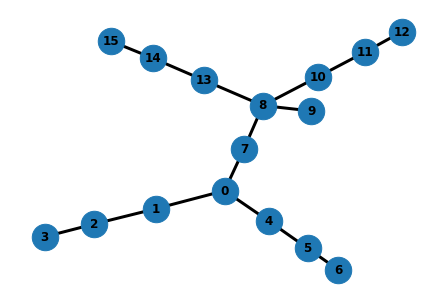

In [ ]:
A1_G = adjacency_to_graph(A1)
for node in range(16):
    print("1-hop neighbor of " + str(node) + ": ", find_path(A1_G, node, 1))

draw_graph(A1_G)

### 2-hop Neighborhood

In [ ]:
A2 = get_k_adjacency(A, 2)
print(A2)

[[0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]


2-hop neighbor of 0:  [[0, 1, 2], [0, 4, 5], [0, 7, 8]]
2-hop neighbor of 1:  [[1, 0, 4], [1, 0, 7], [1, 2, 3]]
2-hop neighbor of 2:  [[2, 1, 0]]
2-hop neighbor of 3:  [[3, 2, 1]]
2-hop neighbor of 4:  [[4, 0, 1], [4, 0, 7], [4, 5, 6]]
2-hop neighbor of 5:  [[5, 4, 0]]
2-hop neighbor of 6:  [[6, 5, 4]]
2-hop neighbor of 7:  [[7, 0, 1], [7, 0, 4], [7, 8, 9], [7, 8, 10], [7, 8, 13]]
2-hop neighbor of 8:  [[8, 7, 0], [8, 10, 11], [8, 13, 14]]
2-hop neighbor of 9:  [[9, 8, 7], [9, 8, 10], [9, 8, 13]]
2-hop neighbor of 10:  [[10, 8, 7], [10, 8, 9], [10, 8, 13], [10, 11, 12]]
2-hop neighbor of 11:  [[11, 10, 8]]
2-hop neighbor of 12:  [[12, 11, 10]]
2-hop neighbor of 13:  [[13, 8, 7], [13, 8, 9], [13, 8, 10], [13, 14, 15]]
2-hop neighbor of 14:  [[14, 13, 8]]
2-hop neighbor of 15:  [[15, 14, 13]]


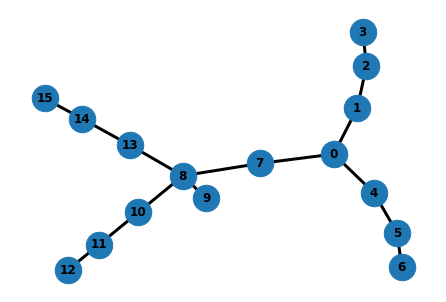

In [ ]:
A1_G = adjacency_to_graph(A1)
for node in range(16):
    print("2-hop neighbor of " + str(node) + ": ", find_path(A1_G, node, 2))

draw_graph(A1_G)

### 3-hop Neighborhood

In [ ]:
A3 = get_k_adjacency(A, 3)
print(A3)

[[0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]


Three-hop neighbor of 0:  [[0, 1, 2, 3], [0, 4, 5, 6], [0, 7, 8, 9], [0, 7, 8, 10], [0, 7, 8, 13]]
Three-hop neighbor of 1:  [[1, 0, 4, 5], [1, 0, 7, 8]]
Three-hop neighbor of 2:  [[2, 1, 0, 4], [2, 1, 0, 7]]
Three-hop neighbor of 3:  [[3, 2, 1, 0]]
Three-hop neighbor of 4:  [[4, 0, 1, 2], [4, 0, 7, 8]]
Three-hop neighbor of 5:  [[5, 4, 0, 1], [5, 4, 0, 7]]
Three-hop neighbor of 6:  [[6, 5, 4, 0]]
Three-hop neighbor of 7:  [[7, 0, 1, 2], [7, 0, 4, 5], [7, 8, 10, 11], [7, 8, 13, 14]]
Three-hop neighbor of 8:  [[8, 7, 0, 1], [8, 7, 0, 4], [8, 10, 11, 12], [8, 13, 14, 15]]
Three-hop neighbor of 9:  [[9, 8, 7, 0], [9, 8, 10, 11], [9, 8, 13, 14]]
Three-hop neighbor of 10:  [[10, 8, 7, 0], [10, 8, 13, 14]]
Three-hop neighbor of 11:  [[11, 10, 8, 7], [11, 10, 8, 9], [11, 10, 8, 13]]
Three-hop neighbor of 12:  [[12, 11, 10, 8]]
Three-hop neighbor of 13:  [[13, 8, 7, 0], [13, 8, 10, 11]]
Three-hop neighbor of 14:  [[14, 13, 8, 7], [14, 13, 8, 9], [14, 13, 8, 10]]
Three-hop neighbor of 15:  [[15

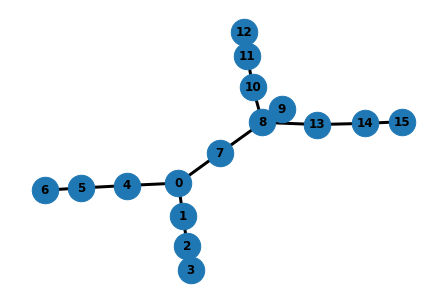

In [ ]:
A1_G = adjacency_to_graph(A1)
for node in range(16):
    print("3-hop neighbor of " + str(node) + ": ", find_path(A1_G, node, 3))

draw_graph(A1_G)

### 4-hop Neighborhood

In [ ]:
A4 = get_k_adjacency(A, 4)
print(A4)

[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0]]


4-hop neighbor of 0:  [[0, 7, 8, 10, 11], [0, 7, 8, 13, 14]]
4-hop neighbor of 1:  [[1, 0, 4, 5, 6], [1, 0, 7, 8, 9], [1, 0, 7, 8, 10], [1, 0, 7, 8, 13]]
4-hop neighbor of 2:  [[2, 1, 0, 4, 5], [2, 1, 0, 7, 8]]
4-hop neighbor of 3:  [[3, 2, 1, 0, 4], [3, 2, 1, 0, 7]]
4-hop neighbor of 4:  [[4, 0, 1, 2, 3], [4, 0, 7, 8, 9], [4, 0, 7, 8, 10], [4, 0, 7, 8, 13]]
4-hop neighbor of 5:  [[5, 4, 0, 1, 2], [5, 4, 0, 7, 8]]
4-hop neighbor of 6:  [[6, 5, 4, 0, 1], [6, 5, 4, 0, 7]]
4-hop neighbor of 7:  [[7, 0, 1, 2, 3], [7, 0, 4, 5, 6], [7, 8, 10, 11, 12], [7, 8, 13, 14, 15]]
4-hop neighbor of 8:  [[8, 7, 0, 1, 2], [8, 7, 0, 4, 5]]
4-hop neighbor of 9:  [[9, 8, 7, 0, 1], [9, 8, 7, 0, 4], [9, 8, 10, 11, 12], [9, 8, 13, 14, 15]]
4-hop neighbor of 10:  [[10, 8, 7, 0, 1], [10, 8, 7, 0, 4], [10, 8, 13, 14, 15]]
4-hop neighbor of 11:  [[11, 10, 8, 7, 0], [11, 10, 8, 13, 14]]
4-hop neighbor of 12:  [[12, 11, 10, 8, 7], [12, 11, 10, 8, 9], [12, 11, 10, 8, 13]]
4-hop neighbor of 13:  [[13, 8, 7, 0, 1], [1

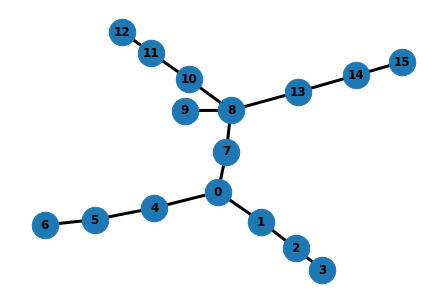

In [ ]:
A1_G = adjacency_to_graph(A1)
for node in range(16):
    print("4-hop neighbor of " + str(node) + ": ", find_path(A1_G, node, 4))

draw_graph(A1_G)

### 5-hop Neighborhood

In [ ]:
A5 = get_k_adjacency(A, 5)
print(A5)

[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


Three-hop neighbor of 0:  [[0, 7, 8, 10, 11, 12], [0, 7, 8, 13, 14, 15]]
Three-hop neighbor of 1:  [[1, 0, 7, 8, 10, 11], [1, 0, 7, 8, 13, 14]]
Three-hop neighbor of 2:  [[2, 1, 0, 4, 5, 6], [2, 1, 0, 7, 8, 9], [2, 1, 0, 7, 8, 10], [2, 1, 0, 7, 8, 13]]
Three-hop neighbor of 3:  [[3, 2, 1, 0, 4, 5], [3, 2, 1, 0, 7, 8]]
Three-hop neighbor of 4:  [[4, 0, 7, 8, 10, 11], [4, 0, 7, 8, 13, 14]]
Three-hop neighbor of 5:  [[5, 4, 0, 1, 2, 3], [5, 4, 0, 7, 8, 9], [5, 4, 0, 7, 8, 10], [5, 4, 0, 7, 8, 13]]
Three-hop neighbor of 6:  [[6, 5, 4, 0, 1, 2], [6, 5, 4, 0, 7, 8]]
Three-hop neighbor of 7:  []
Three-hop neighbor of 8:  [[8, 7, 0, 1, 2, 3], [8, 7, 0, 4, 5, 6]]
Three-hop neighbor of 9:  [[9, 8, 7, 0, 1, 2], [9, 8, 7, 0, 4, 5]]
Three-hop neighbor of 10:  [[10, 8, 7, 0, 1, 2], [10, 8, 7, 0, 4, 5]]
Three-hop neighbor of 11:  [[11, 10, 8, 7, 0, 1], [11, 10, 8, 7, 0, 4], [11, 10, 8, 13, 14, 15]]
Three-hop neighbor of 12:  [[12, 11, 10, 8, 7, 0], [12, 11, 10, 8, 13, 14]]
Three-hop neighbor of 13:  

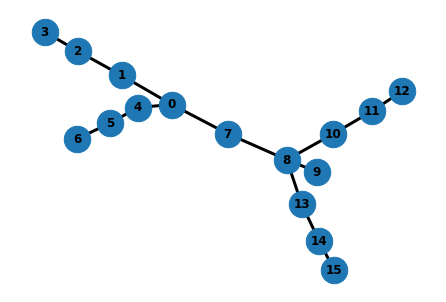

In [ ]:
A1_G = adjacency_to_graph(A1)
for node in range(16):
    print("5-hop neighbor of " + str(node) + ": ", find_path(A1_G, node, 5))

draw_graph(A1_G)

In [ ]:
k = 3
I = np.eye(len(A), dtype=A.dtype)

# if k == 0:
#     return I

Ak = np.minimum(np.linalg.matrix_power(A + I, k), 1) - np.minimum(np.linalg.matrix_power(A + I, k - 1), 1)

print("Aˆ2:\n", np.minimum(np.linalg.matrix_power(A, k), 1))
print("Aˆ1:\n", np.minimum(np.linalg.matrix_power(A, k - 1), 1))

print("Aˆ2 - Aˆ1:\n", Ak)

# if with_self:
#     Ak += (self_factor * I)
    
# return Ak

Aˆ2:
 [[0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0]
 [1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0]
 [0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1]
 [1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0]
 [1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]]
Aˆ1:
 [[1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0

# Ignore the Following

In [ ]:
import networkx as nx
import numpy as np

pos = np.random.rand(10, 2) #coordinates, (x, y) for 10 nodes
print(pos)

connect = [tuple(np.random.random_integers(0, 9, size=(2))) for x in range(8)] #random connections
print(len(connect))
#creation of the graph
graph = nx.Graph()
#adding nodes/connections in the graph
for node in range(len(pos)):
    graph.add_node(node)
graph.add_edges_from(connect)

#plot of the nodes using the (x,y) pairs as coordinates
nx.draw(graph, [(x,y) for x,y in pos], node_size=50)

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


#Initialize the graph
G = nx.Graph(name='G')

#Create nodes
#In this example, the graph will consist of 6 nodes.
#Each node is assigned node feature which corresponds to the node name
for i in range(16):
    G.add_node(i, name=i)


#Define the edges and the edges to the graph
neighbour_base = [(1, 2), (2, 3), (3, 4), (1, 5), (5, 6), (6, 7),
                    (1, 8), (8, 9), (9, 10), (9, 11), (11, 12),
                    (13, 12), (9, 14), (14, 15), (15, 16)]

G.add_edges_from(neighbour_base)

#See graph info
# print('Graph Info:\n', nx.info(G))

#Inspect the node features
print('\nGraph Nodes: ', G.nodes.data())

#Plot the graph
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()